Install dependencies

In [2]:
!pip install -U portalocker>=2.0.0 -q
!pip install -U spacy -q
!python -m spacy download en_core_web_lg -q
!pip install demoji -q
!pip install torchmetrics[text] -q
!pip install transformers>=4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 37.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.5.0 requires spacy<3.6.0,>=3.5.0, but you have spacy 3.6.0 which is incompatible.
2023-07-31 10:32:24.777301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 10:32:25.826988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-31 10:32:27.900230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node

Imports

In [3]:
import json
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, vocab
import torchtext.transforms as T
from collections import Counter, OrderedDict
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import Tensor
import torch.nn as nn
from torch.nn import Transformer
from torch.hub import load_state_dict_from_url
from torchtext.transforms import SentencePieceTokenizer, VocabTransform
import math
from typing import Iterable, List
from timeit import default_timer as timer
import demoji
import re

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading and preprocessing data. Remove emojis, file embeddings and \r, \n

In [4]:
#load samsum dataset
def load(dataset, split):
  with open("drive/MyDrive/"+dataset+"/"+split+".json", "r") as f:
    data = json.load(f)
    return data

In [5]:
train = load("corpus","train")
val = load("corpus","val")
test = load("corpus","test")

In [6]:
#preprocess to remove trailing carriage-return and newline
def preprocess(dataset):
  processed = []
  for x in dataset:
    processed.append({'summary' : re.sub("<[a-z]+_[a-z]+>","",demoji.replace(x['summary'].replace("\r","").replace("\n"," "), '')), 'dialogue' : re.sub("<[a-z]+_[a-z]+>","",demoji.replace(x['dialogue'].replace("\r","").replace("\n"," "), ''))})
  return processed

In [7]:
train_pp_sent = preprocess(train)
val_pp_sent = preprocess(val)
test_pp_sent = preprocess(test)

Instatiate Spacy english word tokenizer for tokennization and determine the vocabulary in the corpus

In [8]:
#define tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_lg')

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# tokenize the whole train dataset
full_text = []
for x in train_pp_sent:
  for _, v in x.items():
    for t in tokenizer(v):
      full_text.append(t)

# determine token frequencies
counter = Counter(full_text)

# sort tokens based on frequency
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)

# ordered dictionary of sorted tokens
ordered_dict = OrderedDict(sorted_by_freq_tuples)

# vocabulary
v1 = vocab(ordered_dict, specials=special_symbols, special_first=True)
v1.set_default_index(UNK_IDX)
len(v1)

38059

Tokenized data

In [9]:
def tokenize(example):
  tokens={}
  for k,v in example.items():
    tokens[k] = tokenizer(v)
  return tokens
train_pp = list(map(tokenize, train_pp_sent))
val_pp = list(map(tokenize, val_pp_sent))
test_pp = list(map(tokenize, test_pp_sent))

Transformations to vectorice and add special tokens, (pad, bos, eos)

In [10]:
padding_idx = 1
bos_idx = 2
eos_idx = 3
src_max_seq_len = 256
tgt_max_seq_len = 64

src_text_transform = T.Sequential(
    T.VocabTransform(v1),
    T.Truncate(src_max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
    T.ToTensor(padding_value=padding_idx),
    T.PadTransform(max_length=src_max_seq_len, pad_value=padding_idx),
)

tgt_text_transform = T.Sequential(
    T.VocabTransform(v1),
    T.Truncate(tgt_max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
    T.ToTensor(padding_value=padding_idx),
    T.PadTransform(max_length=tgt_max_seq_len, pad_value=padding_idx),
)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

Utility functions to generate masks for pad tokens and masks for self attention in the decoder.

In [11]:
# function to create the target mask, to avoid peeking at subsequent tokens in the decoder self-attention stage.
# sz is the maximum length sequence in the batch.
# future token indices are filled with -inf and past token indices with 0. Binarized through exponentiation.
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# function returns source mask, target mask, source_padding_mask and target_padding_mask
# src - dialogue/text
# tgt - summary
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

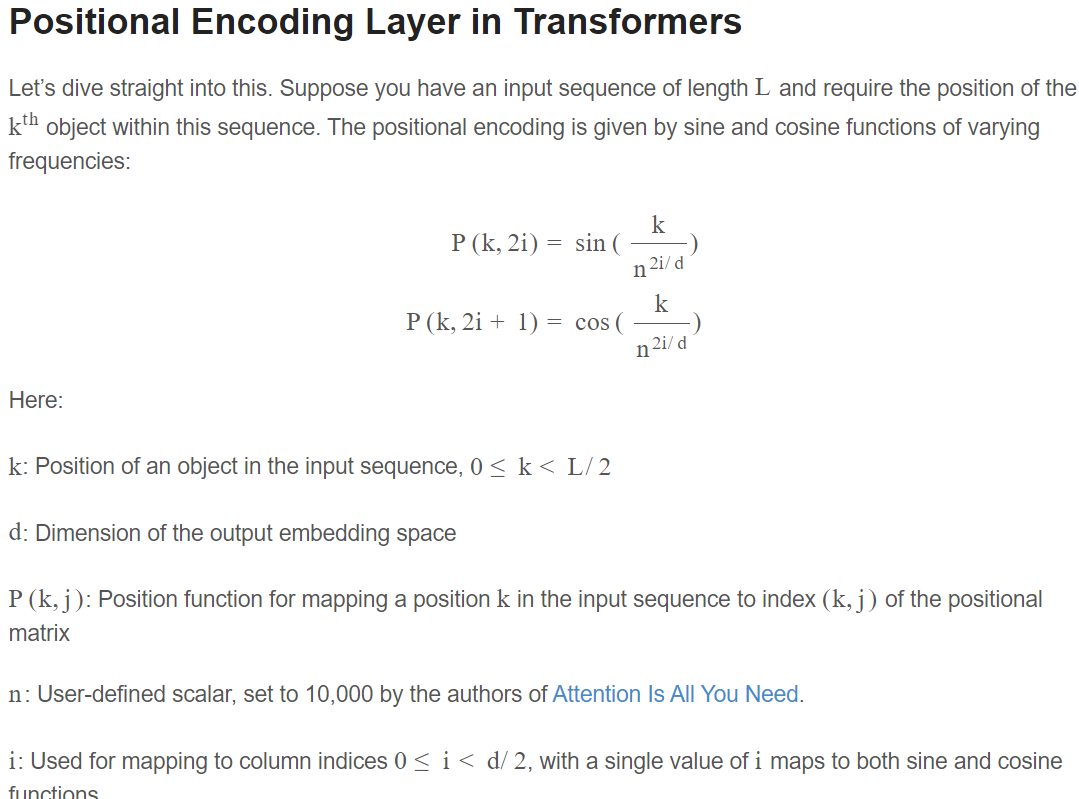

Define the transformer network with  a positional embedding and token embedding layer and a linear generator to generate sequences

In [12]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
#
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 256):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size) # denominator.
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, vocab_size)
        self.tok_emb = TokenEmbedding(vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.tok_emb(src))
        tgt_emb = self.positional_encoding(self.tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tok_emb(tgt)), memory,
                          tgt_mask)

Define model parameters, hyperparameters, loss function, optimizer and a collate function for the data collator

In [13]:
# reproducibility seed
torch.manual_seed(0)
# tokens in vocabulary
VOCAB_SIZE = len(v1.vocab)
# token embedding dimension
EMB_SIZE = 256
# multi-heads in transformer
NHEAD = 4
# hidden forward network input dims
FFN_HID_DIM = 512
# batch size
BATCH_SIZE = 48
# encoder and decoder layers in transformer
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2

# seq2seq model init
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, VOCAB_SIZE, FFN_HID_DIM)

# model parameter init
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

# loss function
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

#optimizer
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001)

# function to collate data samples into batch tensors
def collate_fn(batch):
    dialogues = [x['dialogue'] for x in batch]
    summaries = [x['summary'] for x in batch]
    return src_text_transform(dialogues).transpose(0,1), tgt_text_transform(summaries).transpose(0,1)

Train and Eval logic

In [14]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_dataloader = DataLoader(train_pp, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        # print(src.shape, tgt.shape)
        # print(src, tgt)
        tgt_input = tgt[:-1, :]
        # print(tgt_input.shape)
        # break
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        # print(logits.shape,logits.reshape(-1,logits.shape[-1]).shape, tgt_out.reshape(-1).shape)
        # break
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0
    val_dataloader = DataLoader(val_pp, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

Utility functions for inference. 

In [15]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    # print(memory.shape)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    # print(ys)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = src_text_transform(src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    # print(src_mask)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=tgt_max_seq_len, start_symbol=BOS_IDX).flatten()
    return " ".join(v1.lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Training loop

In [16]:
NUM_EPOCHS = 10
min_loss = 1000
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    if not epoch % 5:
      print(test_pp[70])
      print(translate(transformer, test_pp[70]['dialogue']))
    if val_loss < min_loss:
      min_loss = val_loss
      torch.save({
            'epoch': epoch,
            'model_state_dict': transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
            }, 'drive/MyDrive/checkpoints/eng_tok_latest.pth')
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_jit_internal.py:1297: UserWarning: The inner type of a container is lost when calling torch.jit.isinstance in eager mode. For example, List[int] would become list and therefore falsely return True for List[float] or List[str].
  warnings.warn(


Epoch: 1, Train loss: 7.423, Val loss: 6.135, Epoch time = 45.931s
Epoch: 2, Train loss: 5.687, Val loss: 5.376, Epoch time = 43.472s
Epoch: 3, Train loss: 5.173, Val loss: 5.137, Epoch time = 44.197s
Epoch: 4, Train loss: 4.939, Val loss: 5.012, Epoch time = 44.678s
{'summary': ['Ali', 'left', 'his', 'wallet', 'at', 'Mohammad', "'s", 'place', '.', "Mohammad'll", 'bring', 'it', 'to', 'uni', 'tomorrow', '.'], 'dialogue': ['Ali', ':', 'I', 'think', 'I', 'left', 'my', 'wallet', 'at', 'your', 'place', 'yesterday', '.', 'Could', 'you', 'check', '?', ' ', 'Mohammad', ':', 'Give', 'me', 'a', 'sec', ',', 'I', "'ll", 'have', 'a', 'look', 'around', 'my', 'room', '.', 'Ali', ':', 'OK', '.', 'Mohammad', ':', 'Found', 'it', '!', 'Ali', ':', 'Phew', ',', 'I', 'do', "n't", 'know', 'what', 'I', "'d", 'do', 'if', 'it', 'was', "n't", 'there', '.', 'Can', 'you', 'bring', 'it', 'to', 'uni', 'tomorrow', '?', 'Mohammad', ':', 'Sure', 'thing', '.']}
 The new new new new new new new new new new new new new ne

Import metrics

In [17]:
from torchmetrics.text.rouge import ROUGEScore
from torchmetrics.text.bert import BERTScore
from torchmetrics.text import BLEUScore

Compute metrics on test data

In [18]:
targets = [x['summary'] for x in test_pp_sent]
preds = [translate(transformer, x['dialogue']) for x in test_pp]
# print([preds])
# print([targets])
rouge_score=ROUGEScore()
bert_score = BERTScore()
bleu_score = BLEUScore()
# bleu = bleu_score(preds, targets)
rouge = rouge_score(preds,targets)
bert = bert_score(preds, targets)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:42: UserWarning: The argument `model_name_or_path` was not specified while it is required when the default `transformers` model is used. It will use the default recommended model - 'roberta-large'.
  warnings.warn(*args, **kwargs)  # noqa: B028


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


display metrics

In [19]:
bleu_targets = [[x] for x in targets]
bleu = bleu_score(preds, bleu_targets)
print(bleu)

tensor(0.0075)


In [20]:
print(rouge)

{'rouge1_fmeasure': tensor(0.1416), 'rouge1_precision': tensor(0.1280), 'rouge1_recall': tensor(0.1891), 'rouge2_fmeasure': tensor(0.0198), 'rouge2_precision': tensor(0.0184), 'rouge2_recall': tensor(0.0254), 'rougeL_fmeasure': tensor(0.1171), 'rougeL_precision': tensor(0.1049), 'rougeL_recall': tensor(0.1590), 'rougeLsum_fmeasure': tensor(0.1310), 'rougeLsum_precision': tensor(0.1183), 'rougeLsum_recall': tensor(0.1755)}


In [22]:
bert = {k:v.mean() for k,v in bert.items()}
bert

{'precision': tensor(0.9702), 'recall': tensor(0.9690), 'f1': tensor(0.9696)}